In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)


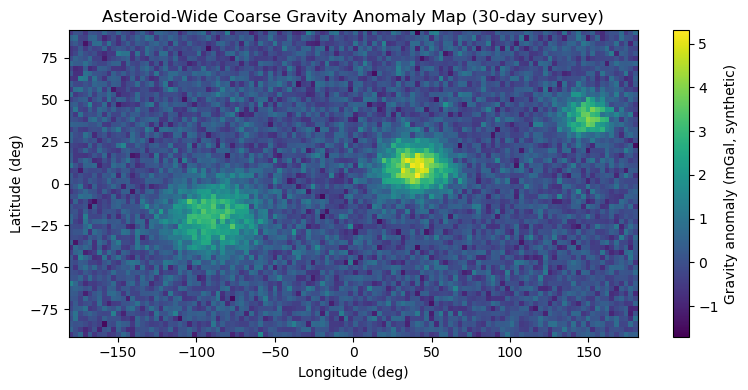

In [6]:
# ---- 1. GLOBAL COARSE GRAVITY MAP ----

# Coarse grid in "lat / lon" over the asteroid
nlat_coarse = 60
nlon_coarse = 120
lats = np.linspace(-90, 90, nlat_coarse)
lons = np.linspace(-180, 180, nlon_coarse)
LONc, LATc = np.meshgrid(lons, lats)

# Background "noise" field, e.g., small-scale variations
gravity_coarse = 0.5 * np.random.normal(size=LONc.shape)

# Add a few positive gravity anomalies (denser regions)
def add_gaussian_anomaly(field, lon0, lat0, amp, sigma_lon, sigma_lat):
    """Add a 2D Gaussian anomaly centered at (lon0, lat0)."""
    gauss = amp * np.exp(-(((LONc - lon0)**2 / (2 * sigma_lon**2)) +
                           ((LATc - lat0)**2 / (2 * sigma_lat**2))))
    return field + gauss

gravity_coarse = add_gaussian_anomaly(gravity_coarse, lon0=40,  lat0=10,
                                      amp=5.0, sigma_lon=15, sigma_lat=10)
gravity_coarse = add_gaussian_anomaly(gravity_coarse, lon0=-90, lat0=-20,
                                      amp=3.0, sigma_lon=20, sigma_lat=15)
gravity_coarse = add_gaussian_anomaly(gravity_coarse, lon0=150, lat0=40,
                                      amp=4.0, sigma_lon=10, sigma_lat=8)

# Plot: global coarse gravity anomaly map
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.pcolormesh(LONc, LATc, gravity_coarse, shading='auto')
cb = plt.colorbar(im, ax=ax, label='Gravity anomaly (mGal, synthetic)')
ax.set_title('Asteroid-Wide Coarse Gravity Anomaly Map (30-day survey)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
plt.tight_layout()
plt.show()


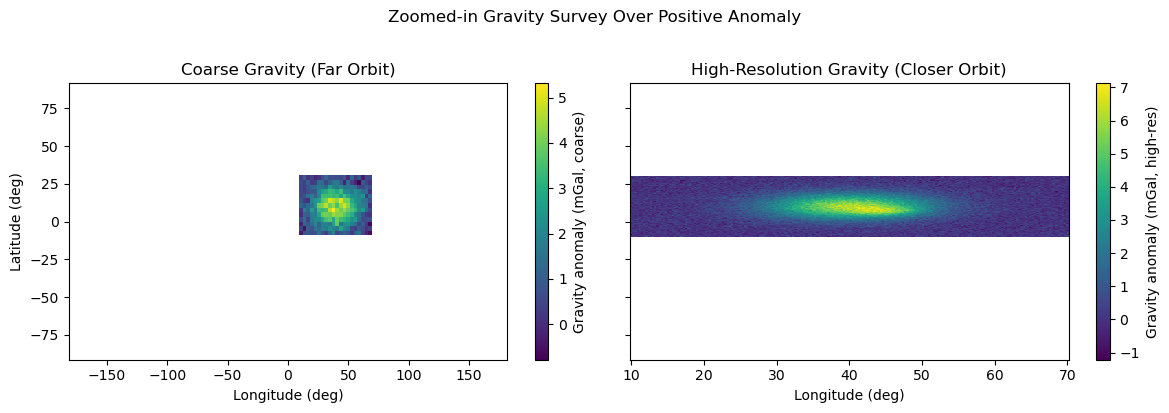

In [3]:
# ---- 2. HIGH-RES GRAVITY MAP OVER SELECTED ANOMALY ----

# Choose the anomaly center you want to zoom into
target_lon = 40.0
target_lat = 10.0

# Define a small window around that anomaly
d_lon = 30   # +/- degrees in longitude
d_lat = 20   # +/- degrees in latitude

lon_hr = np.linspace(target_lon - d_lon, target_lon + d_lon, 200)
lat_hr = np.linspace(target_lat - d_lat, target_lat + d_lat, 150)
LON_hr, LAT_hr = np.meshgrid(lon_hr, lat_hr)

# Simulate high-res gravity: same anomaly but with more detail
# Start with a smoother background
gravity_hr = 0.3 * np.random.normal(size=LON_hr.shape)

# Add a sharper, more localized anomaly (same region)
amp = 6.0
sigma_lon = 8.0
sigma_lat = 6.0
gravity_hr += amp * np.exp(-(((LON_hr - target_lon)**2 / (2 * sigma_lon**2)) +
                             ((LAT_hr - target_lat)**2 / (2 * sigma_lat**2))))

# Add a smaller sub-anomaly (e.g., dense core inside the larger body)
gravity_hr += 2.0 * np.exp(-(((LON_hr - (target_lon + 5))**2 / (2 * 3**2)) +
                             ((LAT_hr - (target_lat - 3))**2 / (2 * 2**2))))

# FIGURE: Side-by-side comparison of coarse vs high-res in the same region

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Left: coarse data cropped to same window
mask = ((LONc >= target_lon - d_lon) & (LONc <= target_lon + d_lon) &
        (LATc >= target_lat - d_lat) & (LATc <= target_lat + d_lat))

# Need a masked array for plotting
gravity_coarse_zoom = np.ma.masked_where(~mask, gravity_coarse)

im0 = axes[0].pcolormesh(LONc, LATc, gravity_coarse_zoom, shading='auto')
plt.colorbar(im0, ax=axes[0], label='Gravity anomaly (mGal, coarse)')
axes[0].set_title('Coarse Gravity (Far Orbit)')
axes[0].set_xlabel('Longitude (deg)')
axes[0].set_ylabel('Latitude (deg)')

# Right: high-res data
im1 = axes[1].pcolormesh(LON_hr, LAT_hr, gravity_hr, shading='auto')
plt.colorbar(im1, ax=axes[1], label='Gravity anomaly (mGal, high-res)')
axes[1].set_title('High-Resolution Gravity (Closer Orbit)')
axes[1].set_xlabel('Longitude (deg)')

plt.suptitle('Zoomed-in Gravity Survey Over Positive Anomaly', y=1.02)
plt.tight_layout()
plt.show()


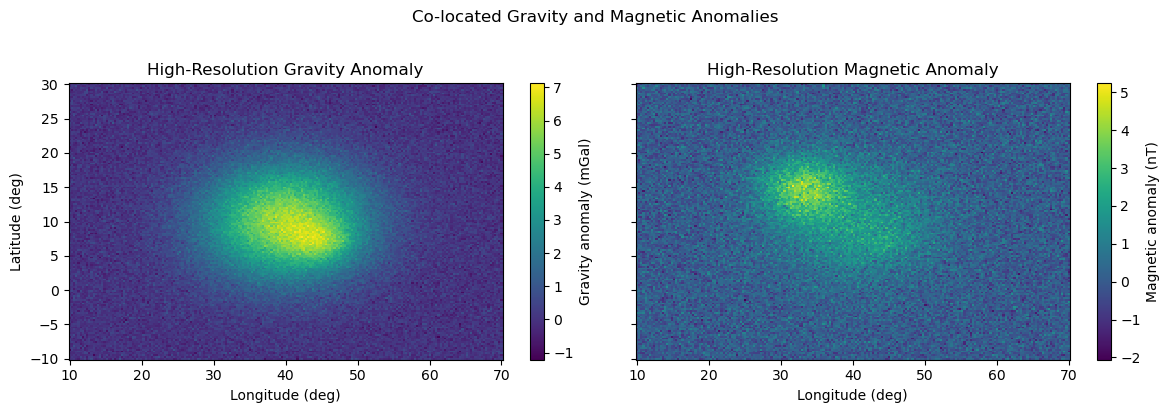

In [4]:
# ---- 3. GRAVITY & MAGNETIC ANOMALIES OVER THE SAME AREA ----

# We'll reuse the high-res coordinates (LON_hr, LAT_hr) and gravity_hr

# Create a synthetic magnetic anomaly field correlated with gravity
# Example: magnetic anomaly ~ 0.3 * gravity anomaly + some noise
noise_mag = np.random.normal(scale=0.5, size=gravity_hr.shape)
magnetic_hr = 0.3 * gravity_hr + noise_mag

# Also add a slightly offset magnetic feature (e.g., magnetized blob not perfectly aligned)
magnetic_hr += 3.0 * np.exp(-(((LON_hr - (target_lon - 7))**2 / (2 * 4**2)) +
                              ((LAT_hr - (target_lat + 5))**2 / (2 * 3**2))))

# FIGURE: Gravity vs Magnetic maps

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im_g = axes[0].pcolormesh(LON_hr, LAT_hr, gravity_hr, shading='auto')
plt.colorbar(im_g, ax=axes[0], label='Gravity anomaly (mGal)')
axes[0].set_title('High-Resolution Gravity Anomaly')
axes[0].set_xlabel('Longitude (deg)')
axes[0].set_ylabel('Latitude (deg)')

im_m = axes[1].pcolormesh(LON_hr, LAT_hr, magnetic_hr, shading='auto')
plt.colorbar(im_m, ax=axes[1], label='Magnetic anomaly (nT)')
axes[1].set_title('High-Resolution Magnetic Anomaly')
axes[1].set_xlabel('Longitude (deg)')

plt.suptitle('Co-located Gravity and Magnetic Anomalies', y=1.02)
plt.tight_layout()
plt.show()


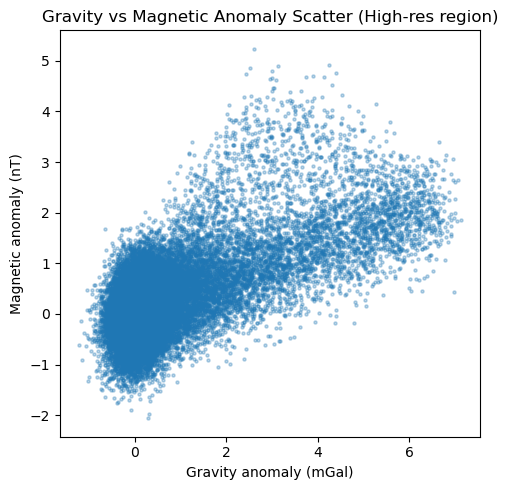

In [5]:
# ---- 3b. Gravity vs Magnetic Cross-Plot ----

fig, ax = plt.subplots(figsize=(5, 5))

# Flatten the arrays & maybe apply a small mask for finite values
g_flat = gravity_hr.ravel()
m_flat = magnetic_hr.ravel()

ax.scatter(g_flat, m_flat, s=5, alpha=0.3)
ax.set_xlabel('Gravity anomaly (mGal)')
ax.set_ylabel('Magnetic anomaly (nT)')
ax.set_title('Gravity vs Magnetic Anomaly Scatter (High-res region)')

plt.tight_layout()
plt.show()
